In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader

import sys
sys.path.append("..")
from src.DeepEvidentialSeg import RUGDH5Dataset, DeepEvidentialSegModelConfig
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from src.DeepEvidentialSeg.utils import image_reverse_transforms, label2name

In [7]:
# 设置设备和混合精度训练
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
scaler = torch.amp.GradScaler(device=device)

# 设置超参数
epochs = 50
lr = 1e-5
batch_size = 16

# 加载数据集
dataset = RUGDH5Dataset('./data/rugd.h5')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# 模型设置部分
## 初始化模型
model_config = DeepEvidentialSegModelConfig()
model = model_config.make_model(device=device)

In [54]:
model.load_state_dict(
    torch.load(
        './checkpoints/deep_evidential_seg_model.pth', 
        map_location=device
    )
)

<All keys matched successfully>

In [55]:
def visualize_with_legend(ax, mask, title, label2name):
    # 1. Get unique classes present in this specific mask
    unique_labels = np.unique(mask)
    
    # 2. Generate a colormap with enough colors for the max label index (25)
    # using 'tab20' or 'jet' usually provides distinct colors
    base_cmap = plt.get_cmap('tab20b', 25) 
    
    # 3. Plot the image
    im = ax.imshow(mask, cmap=base_cmap, vmin=0, vmax=24)
    ax.set_title(title)
    
    # 4. Create the legend handles manually
    legend_patches = []
    for label_idx in unique_labels:
        if label_idx in label2name:
            # Get the color corresponding to this label from the colormap
            color = base_cmap(label_idx / 24.0) 
            patch = mpatches.Patch(color=color, label=f"{label_idx}: {label2name[label_idx]}")
            legend_patches.append(patch)
    
    # 5. Add legend to the side of the plot
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


3 23


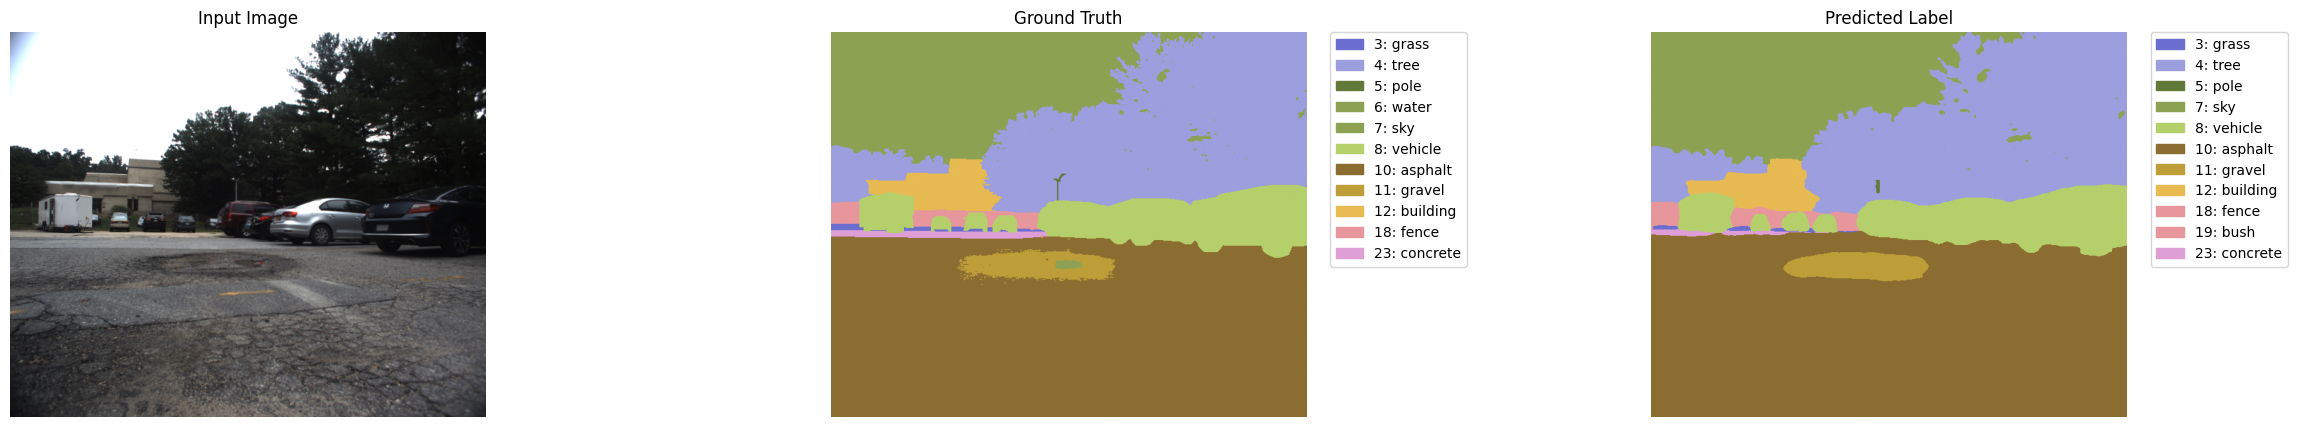

In [68]:
idx = torch.randint(0, len(dataset), (1,)).item()
image, label = dataset[idx]
raw_image = image_reverse_transforms(image)
raw_image = raw_image.permute(1, 2, 0).cpu().numpy()

with torch.no_grad():
    model.eval()
    _, logits = model.classify(image.unsqueeze(0).to(device))
    predicted_label = torch.argmax(logits, dim=-1).cpu().squeeze().numpy()

print(predicted_label.min(), predicted_label.max())

fig, ax = plt.subplots(1, 3, figsize=(30, 5)) # Increased width slightly for legends

# Plot 1: Input Image
ax[0].set_title('Input Image')
ax[0].imshow(raw_image)
ax[0].axis('off')

# Plot 2: Ground Truth with Legend
visualize_with_legend(ax[1], label, 'Ground Truth', label2name)
ax[1].axis('off')

# Plot 3: Predicted Label with Legend
visualize_with_legend(ax[2], predicted_label, 'Predicted Label', label2name)
ax[2].axis('off')

plt.show()